<h1 style="font-size:40px;"><center>Exercise III:<br> Image Segmentation using CNNs
</center></h1>

## Short summary
In this exercise, we will design a CNN-based **encoder-decoder architecture** to segment rgb images. Image segmentation refers to dividing the image into semantically meaningful regions. For instance, representing each object in the scene with a unique color. The current folder has **three files**: 
- **configSegmenter.py:** this involves definitions of all parameters and data paths
- **utilsSegmenter.py:** includes utility functions required to grab and visualize data 
- **runSegmenter.ipynb:** contains the script to design, train and test the network 

Make sure that before running this script, you created an environment and **installed all required libraries** such 
as keras. The very same environment used in Exercise II can be used here as well.

## The data
There exists also a subfolder called **data** which contains the traning, validation, and testing data each has both RGB input images together with the corresponding ground truth segmentation images.


## The exercises
As for the previous lab all exercises are found below.


## The different 'Cells'
This notebook contains several cells with python code, together with the markdown cells (like this one) with only text. Each of the cells with python code has a "header" markdown cell with information about the code. The table below provides a short overview of the code cells. 

| #  |  CellName | CellType | Comment |
| :--- | :-------- | :-------- | :------- |
| 1 | Init | Needed | Sets up the environment|
| 2 | Ex | Exercise 1| A class definition of a CNN model  |
| 3 | Loading | Needed | Loading parameters and initializing the model |
| 4 | Stats | Needed | Show data distribution |
| 5 | Data | Needed | Data augementation |
| 6 | Data | Needed | Generating the data batches |
| 7 | Debug | Needed | Debugging the data |
| 8 | Device | Needed | Selecting CPU/GPU |
| 9 | Optimization | Exercise 2 | Selecting an optimization method |
| 10 | Training | Exercise 2 | Training the model   |
| 11 | Testing | Exercise 2| Testing the  method   | 
| 13 | Plotting | Information  | View some of test samples |
| 13 | Saving | Information  | Saving the model|


In order for you to start with the exercise you need to run all cells. It is important that you do this in the correct order, starting from the top and work you way down the cells. Later when you have started to work with the notebook it may be easier to use the command "Run All" found in the "Cell" dropdown menu.

## Writing the report
First the report should be written within this notebook. We have prepared the last cell in this notebook for you where you should write the report. The report should contain 4 parts:

* Name:
* Introduction: A **few** sentences where you give a small introduction of what you have done in the lab.
* Answers to questions: For each of the questions provide an answer. It can be short answers or a longer ones depending on the nature of the questions, but try to be effective in your writing.
* Conclusion: Summarize your findings in a few sentences.
  

1) We first start with importing all required modules

In [1]:
from tensorflow.compat.v1 import ConfigProto
import os
from configSegmenter import *

##etting GPUS before importing tensorflow to make sure it loads on the right one
cfg = flying_objects_config()
# if cfg.GPU >=0:
#     print("creating network model using gpu " + str(cfg.GPU))
#     os.environ['CUDA_VISIBLE_DEVICES'] = str(cfg.GPU)
# elif cfg.GPU >=-1:
#     print("creating network model using cpu ")
#     os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
#     os.environ["CUDA_VISIBLE_DEVICES"] = ""

from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)


import tensorflow as tf
from tensorflow import keras
from utilsSegmenter import *
from sklearn.metrics import confusion_matrix
import seaborn as sns
from datetime import datetime
import os
import pprint


# import the necessary packages
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D, Conv1D, Convolution2D, Deconvolution2D, Cropping2D, UpSampling2D
from keras.layers import Input,  Conv2DTranspose
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers import Concatenate, concatenate, Reshape
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.models import Model
from keras.callbacks import TensorBoard
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.layers import Input, merge
from keras.regularizers import l2
from keras.layers import Input, merge, Convolution2D, MaxPooling2D, UpSampling2D, Reshape, core, Dropout


gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


2) Here, we have the network model class definition. In this class, the most important function is the one called **create_model()**. As defined in the exercises section, your task is to update the network architecture defined in this function such that the network will return the highest accuracy for the given training, validation, and testing data.

In [2]:
 class SegmenterDNNModel():
    def __init__(self, num_classes=10, batch_size=32, inputShape=(64,64,3), dropout_prob=0.25):
        self.num_classes = num_classes
        self.batch_size = batch_size
        self.inputShape = inputShape
        self.dropout_prob = dropout_prob

    def conv2d_block(self, input_tensor, n_filters, kernel_size=3, batchnorm=True, strides=1):
        # first layer
        x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
                   padding="same")(input_tensor)
        if batchnorm:
            x = BatchNormalization()(x)
        x = Activation("relu")(x)
        # second layer
        x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
                   padding="same")(x)
        if batchnorm:
            x = BatchNormalization()(x)
        x = Activation("relu")(x)
        x_pooled = MaxPooling2D((2, 2), strides=(2, 2))(x)
        
        return x, x_pooled

    def upSampling2d_block(self, input_tensor, input_tensor_pooled, n_filters, kernel_size=3, batchnorm=True):
        upSampling = UpSampling2D((2, 2))(input_tensor)
        concat = concatenate([upSampling, input_tensor_pooled], axis=3)
        up = Conv2D(n_filters, (kernel_size, kernel_size), padding='same')(concat)
        if batchnorm:
            up = BatchNormalization()(up)
        up = Activation('relu')(up)
        up = Conv2D(n_filters, (kernel_size, kernel_size), padding='same')(up)
        if batchnorm:
            up = BatchNormalization()(up)
        up = Activation('relu')(up)
        
        return up
    
    def create_model(self):
        
        batch_norm = True
        
        inputs = Input(shape=self.inputShape)
        
        x1, x_pooled1 = self.conv2d_block(inputs, 16, batchnorm=batch_norm)
        x2, x_pooled2 = self.conv2d_block(x_pooled1, 32, batchnorm=batch_norm)
        
        mid = Conv2D(64, (3, 3), padding='same')(x_pooled2)
        #if batch_norm:
        #    mid = BatchNormalization()(mid)
        mid = Activation('relu')(mid)
        
        up1 = self.upSampling2d_block(mid, x2, 32, batchnorm=batch_norm)
        up2 = self.upSampling2d_block(up1, x1, 16, batchnorm=batch_norm)
        
        
        classify = Conv2D(self.num_classes, (1, 1), activation='sigmoid')(up2)

        model = Model(inputs=inputs, outputs=classify)
        model.summary()
        return model 
      

3) We import the network **hyperparameters** and build a simple cnn by calling the class introduced in the previous step. Please note that to change the hyperparameters, you just need to change the values in the file called **configClassifier.py.**. Do not forget to restart kernels. 

In [3]:
image_shape = (cfg.IMAGE_HEIGHT, cfg.IMAGE_WIDTH, cfg.IMAGE_CHANNEL)
modelObj = SegmenterDNNModel(num_classes=cfg.NUM_CLASS, batch_size=cfg.BATCH_SIZE, inputShape=image_shape, dropout_prob=cfg.DROPOUT_PROB)
model = modelObj.create_model()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 128, 128, 16) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

4) We call the utility function **show_statistics** to display the data distribution. This is just for debugging purpose.

In [4]:
#### show how the data looks like
show_statistics(cfg.training_data_dir, fineGrained=cfg.fineGrained, title=" Training Data Statistics ")
show_statistics(cfg.validation_data_dir, fineGrained=cfg.fineGrained, title=" Validation Data Statistics ")
show_statistics(cfg.testing_data_dir, fineGrained=cfg.fineGrained, title=" Testing Data Statistics ")


######################################################################
##################### Training Data Statistics #####################
######################################################################
total image number 	 10817
total class number 	 3
class square 	 3488 images
class triangle 	 3703 images
class circular 	 3626 images
######################################################################

######################################################################
##################### Validation Data Statistics #####################
######################################################################
total image number 	 2241
total class number 	 3
class square 	 783 images
class triangle 	 745 images
class circular 	 713 images
######################################################################

######################################################################
##################### Testing Data Statistics #####################
##########################

5) We **augment** the data by flipping the image horizontally or vertically. As described in the exercises section below, one of your tasks is to update this data augmentation part in order to increase the network efficiency.

In [5]:
# setup data
if cfg.DATA_AUGMENTATION:
    print("Data is being augmented!")
    aug_parameters = ImageDataGenerator(
        # zoom_range=0.2, # randomly zoom into images
        # rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        #width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        #height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)  # randomly flip images
else:
    print("Data will not be augmented!")
    aug_parameters = ImageDataGenerator(
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

Data is being augmented!


6) We now create batch generators to get small batches from the entire dataset. There is no need to change these functions as they already return **normalized inputs as batches**.

In [6]:
nbr_train_data = get_dataset_size(cfg.training_data_dir)
nbr_valid_data = get_dataset_size(cfg.validation_data_dir)
nbr_test_data = get_dataset_size(cfg.testing_data_dir)
train_batch_generator = generate_segmentation_batches(cfg.training_data_dir, image_shape, cfg.BATCH_SIZE)
valid_batch_generator = generate_segmentation_batches(cfg.validation_data_dir, image_shape, cfg.BATCH_SIZE)
test_batch_generator = generate_segmentation_batches(cfg.testing_data_dir, image_shape, cfg.BATCH_SIZE)
aug_train_batch_generator = generate_augmented_segmentation_batches(train_batch_generator, aug_parameters)
aug_valid_batch_generator = generate_augmented_segmentation_batches(valid_batch_generator, aug_parameters)
print("Data batch generators are created!")

Data batch generators are created!


7) We can visualize how the data looks like for debugging purpose

x (32, 128, 128, 3) float32 0.0 1.0
y (32, 128, 128, 4) float32 0.0 1.0
x (32, 128, 128, 3) float32 0.0 1.0
y (32, 128, 128, 4) float32 0.0 1.0


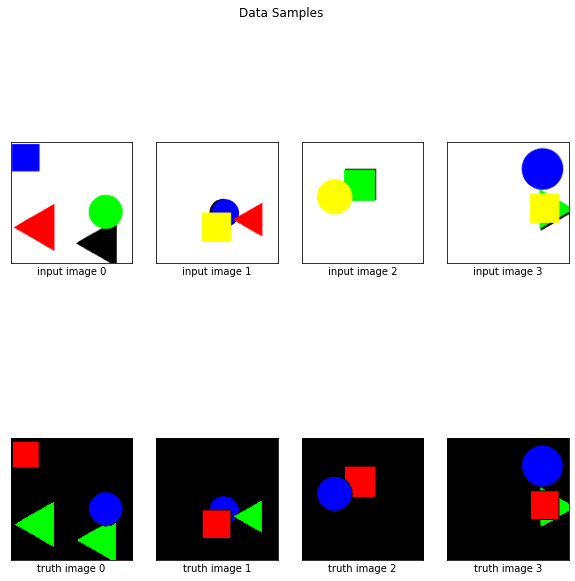

{'BATCH_SIZE': 32,
 'CLASSES': ['square', 'triangle', 'circular', 'background'],
 'DATA_AUGMENTATION': True,
 'DEBUG_MODE': True,
 'DROPOUT_PROB': 0.5,
 'GPU': 0,
 'IMAGE_CHANNEL': 3,
 'IMAGE_HEIGHT': 128,
 'IMAGE_WIDTH': 128,
 'LEARNING_RATE': 0.001,
 'LR_DECAY_FACTOR': 0.1,
 'NUM_CLASS': 4,
 'NUM_EPOCHS': 10,
 'PRINT_EVERY': 20,
 'SAVE_EVERY': 1,
 'fineGrained': False,
 'testing_data_dir': '../data/FlyingObjectDataset_10K/testing',
 'training_data_dir': '../data/FlyingObjectDataset_10K/training',
 'validation_data_dir': '../data/FlyingObjectDataset_10K/validation'}


In [7]:
if cfg.DEBUG_MODE:
    t_x, t_y = next(train_batch_generator)
    print('x', t_x.shape, t_x.dtype, t_x.min(), t_x.max())
    print('y', t_y.shape, t_y.dtype, t_y.min(), t_y.max())
    a_x, a_y = next(aug_train_batch_generator)
    print('x', a_x.shape, a_x.dtype, a_x.min(), a_x.max())
    print('y', a_y.shape, a_y.dtype, a_y.min(), a_y.max())
    plot_sample_data_with_groundtruth(a_x, a_y)
    pprint.pprint (cfg)

8) We select which processing unit to use, either CPU or GPU. In case of having multiple GPUs, we can still select which GPU to use.

9) We set the training configuration. As a part of the exercises, this function can also be updated to test different **optimization methods** such as **SGD, ADAM,** etc.

In [9]:
opt = tf.optimizers.Nadam(cfg.LEARNING_RATE)
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer= opt, metrics=[tf.keras.metrics.MeanIoU(num_classes=cfg.NUM_CLASS), "acc"]) 

10) We can now feed the training and validation data to the network. This will train the network for **some epochs**. Note that the epoch number is also predefined in the file called **configSegmenter.py.**

In [10]:
history = model.fit(aug_train_batch_generator,
          epochs=cfg.NUM_EPOCHS,
          verbose=1,
          steps_per_epoch=(nbr_train_data//cfg.BATCH_SIZE), # total batch number
          validation_steps=(nbr_valid_data // cfg.BATCH_SIZE), # total batch number
          validation_data=valid_batch_generator,
          callbacks=[TensorBoard(log_dir="logs/{}_{}".format(cfg.NUM_EPOCHS,cfg.BATCH_SIZE), write_graph=True, write_images=False,
                                 histogram_freq=0)])

Epoch 1/10
338/338 [==============================] - 37s 96ms/step - loss: 0.8175 - mean_io_u: 0.3750 - acc: 0.8537 - val_loss: 0.7299 - val_mean_io_u: 0.3750 - val_acc: 0.9189
Epoch 2/10
338/338 [==============================] - 30s 88ms/step - loss: 0.0799 - mean_io_u: 0.3750 - acc: 0.9901 - val_loss: 0.5711 - val_mean_io_u: 0.3750 - val_acc: 0.9314
Epoch 3/10
338/338 [==============================] - 30s 88ms/step - loss: 0.0416 - mean_io_u: 0.3750 - acc: 0.9902 - val_loss: 0.0225 - val_mean_io_u: 0.3750 - val_acc: 0.9938
Epoch 4/10
338/338 [==============================] - 30s 88ms/step - loss: 0.0153 - mean_io_u: 0.3750 - acc: 0.9960 - val_loss: 0.0188 - val_mean_io_u: 0.3750 - val_acc: 0.9951
Epoch 5/10
338/338 [==============================] - 30s 88ms/step - loss: 0.0227 - mean_io_u: 0.3750 - acc: 0.9932 - val_loss: 0.0148 - val_mean_io_u: 0.3750 - val_acc: 0.9955
Epoch 6/10
338/338 [==============================] - 30s 88ms/step - loss: 0.0090 - mean_io_u: 0.3750 - acc: 

11) We can test the model with the test data

In [46]:
# testing model
test_result = model.evaluate(test_batch_generator,
                                       steps=(nbr_test_data//cfg.BATCH_SIZE))
test_loss = round(test_result[0], 4)
test_iou = round(test_result[1], 4)
test_acc = round(test_result[2], 4)
print("Test Loss: ", str(test_loss), "Test Mean IoU: ", str(test_iou), "Test Accuracy", str(test_acc))

69/69 [==============================] - 2s 34ms/step - loss: 0.0051 - mean_io_u_4: 0.3750 - acc: 0.9985
Test Loss:  0.0051 Test Mean IoU:  0.375 Test Accuracy 0.9985


12) We can also show sample segmentation results

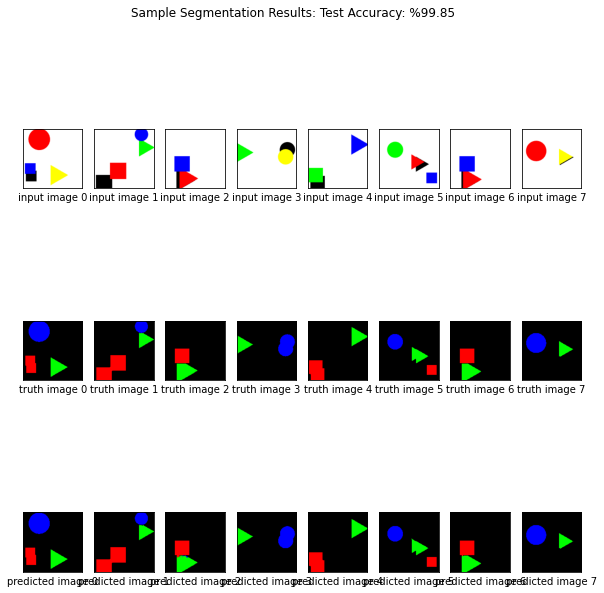

In [47]:
t_data, t_segments = next(test_batch_generator)
pred_segments = model.predict(t_data, batch_size=cfg.BATCH_SIZE)
plot_sample_segmentation_results(t_data, t_segments, pred_segments, test_acc)

13) Finally, we can save the model

In [51]:
# save the model
model.save('./logs/model_epoch_{}_test_acc_{}.h5'.format(cfg.NUM_EPOCHS, str(int(test_acc*10000)))) 

## EXERCISES

Please do all exercises desribed below. Note that all your source code as well as the log folders must be provided as final results **before May 02, 2019.** 


#### Exercise 1)
Update the network architecture given in the function **create_model** of the class SegmenterDNNModel. 

**Hint:** You can add more convolution, max pooling layers etc. Batch normalization and dropout are other options to be considered. You can also try applying different activation functions.

#### Exercise 2) 
Use different **optimization** (e.g. ADAM, SGD, etc) and **regularization** (e.g. batchnorm, dropout) methods to increase the network accuracy. Try adding more skip connections from early encoder layers to deeper decoder layers as well. 

#### Hint:
All network resposes are stored in a **log folder** which is automatically created. To visualize these responses, we can use the tensorboard as follows:
- First make sure that there is a new folder created with **a date and time stamp** under folder **logs**
- Next, open a terminal and type 
    > tensorboard --logdir=./logs
- Finally, open a web browser and type 
    > http://localhost:6006
- You can have an overview of all accuracies on the tensorboard. For more information about tensorboard, please see https://www.tensorflow.org/guide/summaries_and_tensorboard

# The report!


### Name

Karl-Johan Djervbrant

### Introduction

In this lab, the task is to train a convolutional neural network for segmentation with down- and upsampling layers. The dataset consists of over 15000 images with 3 different classes—a triangle, square, and circle.

### Answers to questions

#### Q1: *Update the network architecture given in the function create_model of the class SegmenterDNNModel.*
*Hint: You can add more convolution, max pooling layers etc. Batch normalization and dropout are other options to be considered. You can also try applying different activation functions.*

A1: The first thing I changed was using IoU as a performance measure. Since these images are mostly background, a high accuracy would not necessarily represent a good segmentation model. The Mean IoU measurement, in this case, is the Keras mean IoU metric. Before changing the architecture, the performance was: `Test Loss:  0.1473 Test Mean IoU:  0.375 Test Accuracy 0.9186`.

After changing to a model with two downsampling convolution blocks and two upsampling blocks, inspired by the U-Net model by Ronneberger et al. [[1](https://arxiv.org/pdf/1505.04597.pdf)], the following test result was achieved: `Test Loss:  0.0084 Test Mean IoU:  0.3785 Test Accuracy 0.9969`.

I noted here that the Mean IoU didn't change much, which I, unfortunately, can't explain.

<p>
    <img src="images/epoch_acc_second_model_before_tune.svg" width="300"\>
    <img src="images/results_second_model_before_tune.png" width="300"\>
</p>

#### Q2: *Use different optimization (e.g. ADAM, SGD, etc) and regularization (e.g. batchnorm, dropout) methods to increase the network accuracy. Try adding more skip connections from early encoder layers to deeper decoder layers as well.*

A2: As we can see in the images in Q1, there's still some more room for improvements, especially in the last test image; there are some artifacts. BatchNormalization and more data augmentation might improve the results.
With batch normalization enabled before every activation layer, the model strongly overfitted after 3 epochs. However, with batch normalization disabled on the middle layer, we can see a slight improvement in accuracy, but some artifacts still exist.

<p>
 <img src="images/results_second_model_with_BN.png" width="300"\>
</p>

No improvements were made with more data augmentation settings enabled. A slight increase was seen with 10 epochs instead of 5, now: `Test Loss:  0.0066 Test Mean IoU:  0.375 Test Accuracy 0.998`. Test with different optimizers will be done instead.

| Optimizer | Test Loss | Mean IoU | Test Accuracy |
|:---------:|:---------:|:--------:|:-------------:|
| Adam | 0.0066 | 0.375 | 0.998 |
| SGD | 0.6528 | 0.375 | 0.8941 |
| SGD + Momentum | 0.1632 | 0.375 | 0.9214 |
| Nadam | 0.0051 | 0.375 | 0.9985 |

The best result so far was with Nadam optimizer, with an accuracy of 99.85%, which I consider is very good. In the picture below, we can see how the model performs; the visible artifacts are now mostly gone. As mentioned in the first task, the TensorFlow MeanIoU implementation does not seem to work correctly. 

<p>
 <img src="images/results_second_model_acc_9985.png" width="300"\>
</p>


### Summary

To summarize this, a 16-32-64-32-16 model using Batchnormalization on layer 1,2,4 and 5 and MaxPooling on the downsampling layers was constructed. It achieved `Test Loss:  0.0066 Test Accuracy 0.998`. I've learned that accuracy might not always tell the truth about the performance of your model. In this case, an accuracy of 85% is actually terrible and could not segment the images correctly, and with 90%, there were still lots of artifacts visible. After consultation with another student, I found out that I've implemented the Mean IoU incorrectly, and that's why it didn't work. This was after I had finished every task, hence no reimplementation with Mean IoU working correctly.  

## References

[1] Ronneberger, O., Fischer, P., & Brox, T. (2015, October). U-net: Convolutional networks for biomedical image segmentation. In International Conference on Medical image computing and computer-assisted intervention (pp. 234-241). Springer, Cham. [URL](https://arxiv.org/pdf/1505.04597.pdf).